In [2]:
import torchvision
import tarfile
import torch
import glob
import os

from torchvision.datasets.utils import download_url

# Download data

In [4]:
if (not os.path.isfile('cifar10.tgz')):download_url('https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz','.')

In [5]:
if (not os.path.isdir('data')):tarfile.open('cifar10.tgz',"r:gz").extractall(path="./data")

# ImageFolder

In [2]:
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder

In [3]:
dateset = ImageFolder(r'data\cifar10\train', transform=ToTensor())

In [4]:
dateset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: data\cifar10\train
    StandardTransform
Transform: ToTensor()

In [8]:
img, label = dateset[25001]
print(img.shape,label)

torch.Size([3, 32, 32]) 5


In [9]:
dateset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Random split

In [10]:
from torch.utils.data import random_split

In [11]:
val_size = 0.1
train_size, test_size = int(len(dateset)*(1-val_size)), int(len(dateset)*val_size)

train_ds, test_ds = random_split(dateset,[train_size, test_size])
print(len(train_ds),len(test_ds))

45000 5000


# DataLoader

In [12]:
from torch.utils.data.dataloader import DataLoader

In [13]:
batch_size = 128

In [14]:
train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=4,pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size,shuffle=True, num_workers=4,pin_memory=True)
print(len(train_dl),len(test_dl))

352 40


# Model

In [28]:
randon_seed = 47
torch.manual_seed(randon_seed)

In [29]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
device

device(type='cuda')

In [30]:
model = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),  # 32 x 32 x 32
    nn.ReLU(),
    nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1), # 64 x 32 x 32
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 256 x 16 x 16
    
    nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1), # 128 x 16 x 16
    nn.ReLU(),
    nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1), # 128 x 16 x 16
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 128 x 8 x 8
    
    nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1), # 256 x 16 x 16
    nn.ReLU(),
    nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1), # 256 x 16 x 16
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 256 x 4 x 4
    
    
    nn.Flatten(),
    nn.Linear(256*4*4, 1024), # 2048
    nn.ReLU(),
    nn.Linear(1024,512),
    nn.Linear(512,10),
).to(device)



In [31]:
import torch.optim as optim
from tqdm.auto import tqdm

In [35]:
loss_fn    =  nn.CrossEntropyLoss()
optimizer  =  optim.Adam(model.parameters(),lr=0.001)

# Train it

In [ ]:
train_losses = []
valid_losses = []

In [56]:

num_epoch = 10

for epoch in range(1,num_epoch+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    
    pro = tqdm(total=len(train_dl) + len(test_dl))
    for img, lbl in train_dl:
        img = img.cuda()
        lbl = lbl.cuda()
        optimizer.zero_grad()
        predict = model(img)
        
        loss = loss_fn(predict,lbl)
        loss.backward()
        optimizer.step()
        
        train_loss  +=  loss.item()*img.size(0)
        pro.update(1)
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    
    for img, lbl in test_dl:
        img = img.cuda()
        lbl = lbl.cuda()

        predict = model(img)
        loss = loss_fn(predict,lbl)

        valid_loss += loss.item()*img.size(0)
        
        
        # calculate accuracy
        _, predicted = torch.max(predict.data, 1)
        total       += lbl.size(0)
        accuracy    += (predicted == lbl).sum().item()
        
        
        pro.update(1)
    pro.close()
    
    
    accuracy = (100 * accuracy / total)
    
    
    train_loss = train_loss/len(train_dl.sampler) 
    valid_loss = valid_loss/len(test_dl.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f} val acc:{:.2f}%'.format(epoch,train_loss,valid_loss,accuracy))    

  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:1 Train Loss:0.2686 valid Losss:0.9342 val acc:75.36%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:2 Train Loss:0.2252 valid Losss:0.9190 val acc:75.48%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:3 Train Loss:0.2039 valid Losss:0.9827 val acc:76.02%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:4 Train Loss:0.1722 valid Losss:1.0226 val acc:76.88%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:5 Train Loss:0.1407 valid Losss:1.1245 val acc:75.26%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:6 Train Loss:0.1410 valid Losss:1.2166 val acc:76.22%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:7 Train Loss:0.1263 valid Losss:1.1939 val acc:75.50%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:8 Train Loss:0.1189 valid Losss:1.3775 val acc:75.64%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:9 Train Loss:0.1038 valid Losss:1.3698 val acc:76.34%


  0%|          | 0/392 [00:00<?, ?it/s]

Epoch:10 Train Loss:0.1042 valid Losss:1.3164 val acc:76.02%


# Plot train loss

In [48]:
from matplotlib.pyplot import *

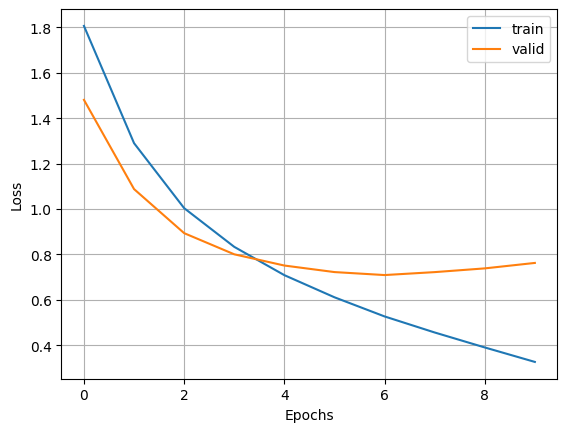

In [55]:
fig, ax = subplots(1)

ax.plot(train_losses,label='train')
ax.plot(valid_losses,label='valid')
grid()
xlabel("Epochs")
ylabel("Loss")

legend()

# Test data

In [39]:
dateset = ImageFolder(r'data\cifar10\test', transform=ToTensor())
final_dl = DataLoader(dateset,64,shuffle=True, num_workers=4,pin_memory=True)

In [40]:
len(final_dl)

157

In [57]:
model.eval()
accuracy = 0.0
total = 0.0
for img, lbl in final_dl:
    # run the model on the test set to predict labels
    
    img = img.cuda()
    lbl = lbl.cuda()
    
    outputs = model(img)
    # the label with the highest energy will be our prediction
    _, predicted = torch.max(outputs.data, 1)
    total    += lbl.size(0)
    accuracy += (predicted == lbl).sum().item()

# compute the accuracy over all test images
accuracy = (100 * accuracy / total)

In [58]:
print(f"Final accuracy : {accuracy}%")

Final accuracy : 75.41%


In [70]:
def predict_img(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dateset.classes[preds[0].item()]

Label : airplane, Predict : bird


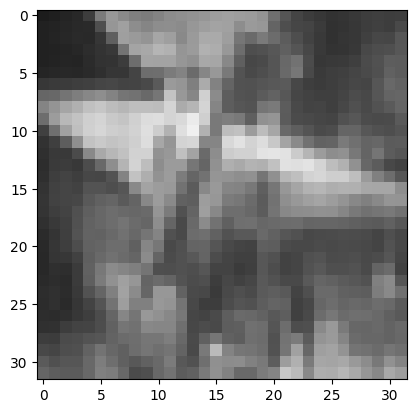

In [94]:
import random
img, labels = dateset[random.randint(0,len(dateset))]
imshow(img.permute(1,2,0))
print(f'Label : {dateset.classes[labels]}, Predict : {predict_img(img, model)}')

# Save the model

In [96]:
if (not os.path.isdir("models")): os.mkdir("models")
torch.save(model.state_dict(), "models/cifar10.pth")

In [99]:
load_model = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),  # 32 x 32 x 32
    nn.ReLU(),
    nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1), # 64 x 32 x 32
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 256 x 16 x 16
    
    nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1), # 128 x 16 x 16
    nn.ReLU(),
    nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1), # 128 x 16 x 16
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 128 x 8 x 8
    
    nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1), # 256 x 16 x 16
    nn.ReLU(),
    nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1), # 256 x 16 x 16
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 256 x 4 x 4
    
    
    nn.Flatten(),
    nn.Linear(256*4*4, 1024), # 2048
    nn.ReLU(),
    nn.Linear(1024,512),
    nn.Linear(512,10),
).to(device)

In [100]:
load_model.load_state_dict(torch.load("models/cifar10.pth"))

<All keys matched successfully>

In [103]:
load_model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=4096, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): Linear(in_features=5